# 1. Importing Libraries

In [1]:
!pip install split-folders
import splitfolders

In [16]:
input_folder = '/home/dhrubo/Downloads/FracAtlas/fracture11'
splitfolders.ratio(input_folder, output="/home/dhrubo/Downloads/FracAtlas/OUTPUT", 
                   seed=42, ratio=(.8, .1, .1), 
                   group_prefix=None) # default values

Copying files: 9600 files [00:06, 1456.73 files/s]


You should download timm library (pip install timm)

In [3]:
!pip install timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 697.7 kB/s eta 0:00:00 kB/s eta 0:00:01:01


In [4]:
!pip install einops

In [17]:
import torchvision
import torch
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import random
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchvision.transforms as transforms
import cv2
import glob
import math
import timm
from PIL import ImageFilter
from einops import rearrange
from timm.loss import LabelSmoothingCrossEntropy

# 2. Configurations

In [18]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

num_epochs = 10
lr = 0.001
batch_size = 32
num_workers = 4

In [19]:
class_names = os.listdir('/home/dhrubo/Downloads/FracAtlas/OUTPUT/train')
class_names.sort()
class_len = len(class_names)

# 3. Building Dataset

In [20]:
import glob
import random
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class fracture_Dataset(Dataset):
    
    def __init__(self, dataset_name, img_dir='/home/dhrubo/Downloads/FracAtlas/OUTPUT/train'):
        self.dataset_name = dataset_name
        self.img_dir = img_dir
        self.class_names = sorted([name for name in os.listdir(img_dir)])
        
        self.img_path = []
        for name in self.class_names:
            self.img_path.extend(glob.glob(f'{img_dir}/{name}/*.jpg'))
        
        self.labels = np.array([self.class_names.index(path.split('/')[-2]) for path in self.img_path])
        
        self.img_transforms = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),  # Convert image to tensor
        ])
        
    def __getitem__(self, index):
        img = Image.open(self.img_path[index]).convert('RGB')
        img = self.img_transforms(img)
        lbl = torch.tensor(self.labels[index], dtype=torch.long)
        
        return img, lbl
    
    def __len__(self):
        return len(self.img_path)

# maxvit_tiny_tf_224maxvit_tiny_tf_224

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from timm import create_model
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np
import copy

# Custom Dataset with Error Handling
class Sports_Dataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_paths = []
        self.labels = []
        self.class_names = sorted(os.listdir(img_dir))

        for label, class_name in enumerate(self.class_names):
            class_folder = os.path.join(img_dir, class_name)
            if not os.path.isdir(class_folder):
                continue  # Skip if not a directory
            for img_name in os.listdir(class_folder):
                img_path = os.path.join(class_folder, img_name)
                if os.path.isfile(img_path):
                    self.img_paths.append(img_path)
                    self.labels.append(label)
        
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except (OSError, Image.DecompressionBombError) as e:
            print(f"Skipping corrupted image: {img_path}. Error: {e}")
            image = Image.new('RGB', (224, 224), (0, 0, 0))
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Hyperparameters
batch_size = 32  # Adjust based on GPU memory
num_workers = 2
num_epochs = 50
learning_rate = 1e-4
weight_decay = 1e-4  # L2 regularization
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Transforms with Augmentation for Training
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

# Validation/Test Transforms (without Augmentation)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

# Initialize Dataset
train_dataset = Sports_Dataset('/home/dhrubo/Downloads/lung cancer/lung/train', transform=train_transform)
val_dataset = Sports_Dataset('/home/dhrubo/Downloads/lung cancer/lung/val', transform=val_transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# Initialize ConvNeXt-Tiny Model
model = create_model('maxvit_tiny_tf_224', pretrained=True, num_classes=len(train_dataset.class_names))
model = model.to(device)

# Loss Function
criterion = nn.CrossEntropyLoss()

# Optimizer and Scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# Variables to Track Best Model
best_val_loss = np.inf
best_model_wts = copy.deepcopy(model.state_dict())

# Training Loop
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_train_loss = running_loss / len(train_dataset)
    epoch_train_acc = 100.0 * correct / total
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)
    
    # Validation Phase
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    epoch_val_loss = val_running_loss / len(val_dataset)
    epoch_val_acc = 100.0 * val_correct / val_total
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)
    
    print(f"Epoch {epoch}/{num_epochs}: "
          f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}% | "
          f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%")
    
    # Check for Best Model
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
    
    # Step the Scheduler
    scheduler.step()

# Load Best Model Weights
model.load_state_dict(best_model_wts)

# Test Evaluation
print("\n--- Testing Phase ---")
test_dataset = Sports_Dataset('/home/dhrubo/Downloads/lung cancer/lung/test', transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100.0 * test_correct / test_total
print(f"\nTest Accuracy: {test_accuracy:.2f}%")

Epoch 1/50: 100%|███████████████████████████████| 28/28 [00:06<00:00,  4.14it/s]


Epoch 1/50: Train Loss: 0.6141, Train Acc: 77.97% | Val Loss: 0.3741, Val Acc: 86.24%


Epoch 2/50: 100%|███████████████████████████████| 28/28 [00:06<00:00,  4.36it/s]


Epoch 2/50: Train Loss: 0.3784, Train Acc: 85.39% | Val Loss: 0.2904, Val Acc: 88.07%


Epoch 3/50: 100%|███████████████████████████████| 28/28 [00:06<00:00,  4.38it/s]


Epoch 3/50: Train Loss: 0.3235, Train Acc: 86.64% | Val Loss: 0.2715, Val Acc: 90.83%


Epoch 4/50: 100%|███████████████████████████████| 28/28 [00:06<00:00,  4.37it/s]


Epoch 4/50: Train Loss: 0.2920, Train Acc: 88.24% | Val Loss: 0.3723, Val Acc: 89.91%


Epoch 5/50: 100%|███████████████████████████████| 28/28 [00:06<00:00,  4.33it/s]


Epoch 5/50: Train Loss: 0.3174, Train Acc: 86.53% | Val Loss: 0.2578, Val Acc: 92.66%


Epoch 6/50: 100%|███████████████████████████████| 28/28 [00:06<00:00,  4.32it/s]


Epoch 6/50: Train Loss: 0.2721, Train Acc: 89.16% | Val Loss: 0.2503, Val Acc: 93.58%


Epoch 7/50: 100%|███████████████████████████████| 28/28 [00:06<00:00,  4.35it/s]


Epoch 7/50: Train Loss: 0.2343, Train Acc: 90.18% | Val Loss: 0.2446, Val Acc: 93.58%


Epoch 8/50: 100%|███████████████████████████████| 28/28 [00:06<00:00,  4.36it/s]


Epoch 8/50: Train Loss: 0.2288, Train Acc: 90.18% | Val Loss: 0.2671, Val Acc: 92.66%


Epoch 9/50: 100%|███████████████████████████████| 28/28 [00:06<00:00,  4.36it/s]


Epoch 9/50: Train Loss: 0.1781, Train Acc: 91.89% | Val Loss: 0.5130, Val Acc: 67.89%


Epoch 10/50: 100%|██████████████████████████████| 28/28 [00:06<00:00,  4.35it/s]


Epoch 10/50: Train Loss: 0.2081, Train Acc: 91.21% | Val Loss: 0.2322, Val Acc: 90.83%


Epoch 11/50: 100%|██████████████████████████████| 28/28 [00:06<00:00,  4.35it/s]


Epoch 11/50: Train Loss: 0.1532, Train Acc: 93.72% | Val Loss: 0.1688, Val Acc: 95.41%


Epoch 12/50: 100%|██████████████████████████████| 28/28 [00:06<00:00,  4.35it/s]


Epoch 12/50: Train Loss: 0.1399, Train Acc: 94.52% | Val Loss: 0.1599, Val Acc: 95.41%


Epoch 13/50: 100%|██████████████████████████████| 28/28 [00:06<00:00,  4.35it/s]


Epoch 13/50: Train Loss: 0.1395, Train Acc: 94.29% | Val Loss: 0.3123, Val Acc: 87.16%


Epoch 14/50: 100%|██████████████████████████████| 28/28 [00:06<00:00,  4.34it/s]


Epoch 14/50: Train Loss: 0.1379, Train Acc: 94.41% | Val Loss: 0.1484, Val Acc: 95.41%


Epoch 15/50: 100%|██████████████████████████████| 28/28 [00:06<00:00,  4.34it/s]


Epoch 15/50: Train Loss: 0.1464, Train Acc: 93.72% | Val Loss: 0.2592, Val Acc: 88.07%


Epoch 16/50: 100%|██████████████████████████████| 28/28 [00:06<00:00,  4.35it/s]


Epoch 16/50: Train Loss: 0.1410, Train Acc: 94.41% | Val Loss: 0.2043, Val Acc: 92.66%


Epoch 17/50: 100%|██████████████████████████████| 28/28 [00:06<00:00,  4.35it/s]


Epoch 17/50: Train Loss: 0.1114, Train Acc: 95.43% | Val Loss: 0.1900, Val Acc: 95.41%


Epoch 18/50: 100%|██████████████████████████████| 28/28 [00:06<00:00,  4.35it/s]


Epoch 18/50: Train Loss: 0.1183, Train Acc: 94.98% | Val Loss: 0.0718, Val Acc: 98.17%


Epoch 19/50: 100%|██████████████████████████████| 28/28 [00:06<00:00,  4.34it/s]


Epoch 19/50: Train Loss: 0.0844, Train Acc: 96.92% | Val Loss: 0.1182, Val Acc: 97.25%


Epoch 20/50: 100%|██████████████████████████████| 28/28 [00:06<00:00,  4.35it/s]


Epoch 20/50: Train Loss: 0.0878, Train Acc: 95.32% | Val Loss: 0.1484, Val Acc: 95.41%


Epoch 21/50: 100%|██████████████████████████████| 28/28 [00:06<00:00,  4.35it/s]


Epoch 21/50: Train Loss: 0.0795, Train Acc: 97.03% | Val Loss: 0.1147, Val Acc: 97.25%


Epoch 22/50: 100%|██████████████████████████████| 28/28 [00:06<00:00,  4.34it/s]


Epoch 22/50: Train Loss: 0.0714, Train Acc: 97.37% | Val Loss: 0.0938, Val Acc: 96.33%


Epoch 23/50: 100%|██████████████████████████████| 28/28 [00:06<00:00,  4.34it/s]


Epoch 23/50: Train Loss: 0.0986, Train Acc: 96.46% | Val Loss: 0.1412, Val Acc: 96.33%


Epoch 24/50: 100%|██████████████████████████████| 28/28 [00:06<00:00,  4.34it/s]


Epoch 24/50: Train Loss: 0.0685, Train Acc: 97.60% | Val Loss: 0.0987, Val Acc: 98.17%


Epoch 25/50: 100%|██████████████████████████████| 28/28 [00:06<00:00,  4.34it/s]


Epoch 25/50: Train Loss: 0.0775, Train Acc: 97.26% | Val Loss: 0.0705, Val Acc: 99.08%


Epoch 26/50: 100%|██████████████████████████████| 28/28 [00:06<00:00,  4.34it/s]


Epoch 26/50: Train Loss: 0.0643, Train Acc: 98.29% | Val Loss: 0.1512, Val Acc: 95.41%


Epoch 27/50: 100%|██████████████████████████████| 28/28 [00:06<00:00,  4.34it/s]


Epoch 27/50: Train Loss: 0.0777, Train Acc: 97.26% | Val Loss: 0.1075, Val Acc: 98.17%


Epoch 28/50: 100%|██████████████████████████████| 28/28 [00:06<00:00,  4.35it/s]


Epoch 28/50: Train Loss: 0.0668, Train Acc: 97.26% | Val Loss: 0.1510, Val Acc: 96.33%


Epoch 29/50: 100%|██████████████████████████████| 28/28 [00:06<00:00,  4.34it/s]


Epoch 29/50: Train Loss: 0.0665, Train Acc: 97.95% | Val Loss: 0.0684, Val Acc: 98.17%


Epoch 30/50: 100%|██████████████████████████████| 28/28 [00:06<00:00,  4.35it/s]


Epoch 30/50: Train Loss: 0.0598, Train Acc: 97.15% | Val Loss: 0.1110, Val Acc: 97.25%


Epoch 31/50: 100%|██████████████████████████████| 28/28 [00:06<00:00,  4.35it/s]


Epoch 31/50: Train Loss: 0.0535, Train Acc: 98.29% | Val Loss: 0.0875, Val Acc: 98.17%


Epoch 32/50: 100%|██████████████████████████████| 28/28 [00:06<00:00,  4.34it/s]


Epoch 32/50: Train Loss: 0.0501, Train Acc: 97.83% | Val Loss: 0.0586, Val Acc: 99.08%


Epoch 33/50: 100%|██████████████████████████████| 28/28 [00:06<00:00,  4.34it/s]


Epoch 33/50: Train Loss: 0.0611, Train Acc: 96.58% | Val Loss: 0.0810, Val Acc: 98.17%


Epoch 34/50: 100%|██████████████████████████████| 28/28 [00:06<00:00,  4.35it/s]


Epoch 34/50: Train Loss: 0.0494, Train Acc: 98.06% | Val Loss: 0.0626, Val Acc: 99.08%


Epoch 35/50: 100%|██████████████████████████████| 28/28 [00:06<00:00,  4.34it/s]


Epoch 35/50: Train Loss: 0.0414, Train Acc: 98.29% | Val Loss: 0.0663, Val Acc: 99.08%


Epoch 36/50: 100%|██████████████████████████████| 28/28 [00:06<00:00,  4.34it/s]


Epoch 36/50: Train Loss: 0.0423, Train Acc: 98.17% | Val Loss: 0.0600, Val Acc: 99.08%


Epoch 37/50: 100%|██████████████████████████████| 28/28 [00:06<00:00,  4.34it/s]


Epoch 37/50: Train Loss: 0.0361, Train Acc: 98.17% | Val Loss: 0.0617, Val Acc: 99.08%


Epoch 38/50: 100%|██████████████████████████████| 28/28 [00:06<00:00,  4.34it/s]


Epoch 38/50: Train Loss: 0.0396, Train Acc: 98.40% | Val Loss: 0.0611, Val Acc: 99.08%


Epoch 39/50: 100%|██████████████████████████████| 28/28 [00:06<00:00,  4.33it/s]


Epoch 39/50: Train Loss: 0.0445, Train Acc: 98.40% | Val Loss: 0.0610, Val Acc: 99.08%


Epoch 40/50: 100%|██████████████████████████████| 28/28 [00:06<00:00,  4.34it/s]


Epoch 40/50: Train Loss: 0.0536, Train Acc: 98.17% | Val Loss: 0.0690, Val Acc: 98.17%


Epoch 41/50: 100%|██████████████████████████████| 28/28 [00:06<00:00,  4.34it/s]


Epoch 41/50: Train Loss: 0.0418, Train Acc: 98.40% | Val Loss: 0.0586, Val Acc: 99.08%


Epoch 42/50: 100%|██████████████████████████████| 28/28 [00:06<00:00,  4.35it/s]


Epoch 42/50: Train Loss: 0.0337, Train Acc: 98.74% | Val Loss: 0.0680, Val Acc: 99.08%


Epoch 43/50: 100%|██████████████████████████████| 28/28 [00:06<00:00,  4.28it/s]


Epoch 43/50: Train Loss: 0.0353, Train Acc: 98.97% | Val Loss: 0.0687, Val Acc: 99.08%


Epoch 44/50: 100%|██████████████████████████████| 28/28 [00:06<00:00,  4.35it/s]


Epoch 44/50: Train Loss: 0.0321, Train Acc: 98.86% | Val Loss: 0.0705, Val Acc: 98.17%


Epoch 45/50: 100%|██████████████████████████████| 28/28 [00:06<00:00,  4.33it/s]


Epoch 45/50: Train Loss: 0.0473, Train Acc: 98.86% | Val Loss: 0.0710, Val Acc: 98.17%


Epoch 46/50: 100%|██████████████████████████████| 28/28 [00:06<00:00,  4.34it/s]


Epoch 46/50: Train Loss: 0.0330, Train Acc: 98.29% | Val Loss: 0.0749, Val Acc: 98.17%


Epoch 47/50: 100%|██████████████████████████████| 28/28 [00:06<00:00,  4.33it/s]


Epoch 47/50: Train Loss: 0.0428, Train Acc: 98.29% | Val Loss: 0.0685, Val Acc: 99.08%


Epoch 48/50: 100%|██████████████████████████████| 28/28 [00:06<00:00,  4.34it/s]


Epoch 48/50: Train Loss: 0.0300, Train Acc: 98.63% | Val Loss: 0.0690, Val Acc: 99.08%


Epoch 49/50: 100%|██████████████████████████████| 28/28 [00:06<00:00,  4.32it/s]


Epoch 49/50: Train Loss: 0.0527, Train Acc: 97.83% | Val Loss: 0.0688, Val Acc: 99.08%


Epoch 50/50: 100%|██████████████████████████████| 28/28 [00:06<00:00,  4.34it/s]


Epoch 50/50: Train Loss: 0.0570, Train Acc: 97.83% | Val Loss: 0.0659, Val Acc: 99.08%

--- Testing Phase ---


Testing: 100%|████████████████████████████████████| 4/4 [00:00<00:00,  9.41it/s]


Test Accuracy: 98.21%


# NEXT_VIT

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from timm import create_model
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np
import copy

# Custom Dataset with Error Handling
class Sports_Dataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_paths = []
        self.labels = []
        self.class_names = sorted(os.listdir(img_dir))

        for label, class_name in enumerate(self.class_names):
            class_folder = os.path.join(img_dir, class_name)
            if not os.path.isdir(class_folder):
                continue  # Skip if not a directory
            for img_name in os.listdir(class_folder):
                img_path = os.path.join(class_folder, img_name)
                if os.path.isfile(img_path):
                    self.img_paths.append(img_path)
                    self.labels.append(label)
        
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except (OSError, Image.DecompressionBombError) as e:
            print(f"Skipping corrupted image: {img_path}. Error: {e}")
            image = Image.new('RGB', (224, 224), (0, 0, 0))
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Hyperparameters
batch_size = 32  # Adjust based on GPU memory
num_workers = 2
num_epochs = 50
learning_rate = 1e-4
weight_decay = 1e-4  # L2 regularization
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Transforms with Augmentation for Training
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

# Validation/Test Transforms (without Augmentation)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

# Initialize Dataset
train_dataset = Sports_Dataset('/home/dhrubo/Downloads/lung cancer/lung/train', transform=train_transform)
val_dataset = Sports_Dataset('/home/dhrubo/Downloads/lung cancer/lung/val', transform=val_transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# Initialize ConvNeXt-Tiny Model
model = create_model('nextvit_small', pretrained=True, num_classes=len(train_dataset.class_names))
model = model.to(device)

# Loss Function
criterion = nn.CrossEntropyLoss()

# Optimizer and Scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# Variables to Track Best Model
best_val_loss = np.inf
best_model_wts = copy.deepcopy(model.state_dict())

# Training Loop
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_train_loss = running_loss / len(train_dataset)
    epoch_train_acc = 100.0 * correct / total
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)
    
    # Validation Phase
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    epoch_val_loss = val_running_loss / len(val_dataset)
    epoch_val_acc = 100.0 * val_correct / val_total
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)
    
    print(f"Epoch {epoch}/{num_epochs}: "
          f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}% | "
          f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%")
    
    # Check for Best Model
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
    
    # Step the Scheduler
    scheduler.step()

# Load Best Model Weights
model.load_state_dict(best_model_wts)

# Test Evaluation
print("\n--- Testing Phase ---")
test_dataset = Sports_Dataset('/home/dhrubo/Downloads/lung cancer/lung/test', transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100.0 * test_correct / test_total
print(f"\nTest Accuracy: {test_accuracy:.2f}%")

Epoch 1/50: 100%|███████████████████████████████| 28/28 [00:04<00:00,  6.51it/s]


Epoch 1/50: Train Loss: 0.5281, Train Acc: 79.00% | Val Loss: 0.4262, Val Acc: 84.40%


Epoch 2/50: 100%|███████████████████████████████| 28/28 [00:04<00:00,  6.72it/s]


Epoch 2/50: Train Loss: 0.4065, Train Acc: 83.56% | Val Loss: 0.3128, Val Acc: 89.91%


Epoch 3/50: 100%|███████████████████████████████| 28/28 [00:04<00:00,  6.73it/s]


Epoch 3/50: Train Loss: 0.3663, Train Acc: 85.39% | Val Loss: 0.4721, Val Acc: 72.48%


Epoch 4/50: 100%|███████████████████████████████| 28/28 [00:04<00:00,  6.74it/s]


Epoch 4/50: Train Loss: 0.3321, Train Acc: 86.42% | Val Loss: 0.2929, Val Acc: 90.83%


Epoch 5/50: 100%|███████████████████████████████| 28/28 [00:04<00:00,  6.75it/s]


Epoch 5/50: Train Loss: 0.3472, Train Acc: 86.87% | Val Loss: 0.4031, Val Acc: 77.98%


Epoch 6/50: 100%|███████████████████████████████| 28/28 [00:04<00:00,  6.75it/s]


Epoch 6/50: Train Loss: 0.3109, Train Acc: 86.64% | Val Loss: 0.3005, Val Acc: 88.07%


Epoch 7/50: 100%|███████████████████████████████| 28/28 [00:04<00:00,  6.74it/s]


Epoch 7/50: Train Loss: 0.2961, Train Acc: 88.24% | Val Loss: 0.2003, Val Acc: 93.58%


Epoch 8/50: 100%|███████████████████████████████| 28/28 [00:04<00:00,  6.75it/s]


Epoch 8/50: Train Loss: 0.2671, Train Acc: 88.93% | Val Loss: 0.2224, Val Acc: 92.66%


Epoch 9/50: 100%|███████████████████████████████| 28/28 [00:04<00:00,  6.75it/s]


Epoch 9/50: Train Loss: 0.2326, Train Acc: 89.04% | Val Loss: 0.5877, Val Acc: 70.64%


Epoch 10/50: 100%|██████████████████████████████| 28/28 [00:04<00:00,  6.75it/s]


Epoch 10/50: Train Loss: 0.2415, Train Acc: 90.18% | Val Loss: 0.1948, Val Acc: 90.83%


Epoch 11/50: 100%|██████████████████████████████| 28/28 [00:04<00:00,  6.70it/s]


Epoch 11/50: Train Loss: 0.2615, Train Acc: 89.73% | Val Loss: 0.3614, Val Acc: 83.49%


Epoch 12/50: 100%|██████████████████████████████| 28/28 [00:04<00:00,  6.74it/s]


Epoch 12/50: Train Loss: 0.2286, Train Acc: 91.44% | Val Loss: 0.1413, Val Acc: 96.33%


Epoch 13/50: 100%|██████████████████████████████| 28/28 [00:04<00:00,  6.74it/s]


Epoch 13/50: Train Loss: 0.1892, Train Acc: 92.35% | Val Loss: 0.1411, Val Acc: 94.50%


Epoch 14/50: 100%|██████████████████████████████| 28/28 [00:04<00:00,  6.74it/s]


Epoch 14/50: Train Loss: 0.1858, Train Acc: 93.61% | Val Loss: 0.3006, Val Acc: 90.83%


Epoch 15/50: 100%|██████████████████████████████| 28/28 [00:04<00:00,  6.74it/s]


Epoch 15/50: Train Loss: 0.1927, Train Acc: 92.92% | Val Loss: 0.1646, Val Acc: 93.58%


Epoch 16/50: 100%|██████████████████████████████| 28/28 [00:04<00:00,  6.74it/s]


Epoch 16/50: Train Loss: 0.1657, Train Acc: 93.84% | Val Loss: 0.0848, Val Acc: 96.33%


Epoch 17/50: 100%|██████████████████████████████| 28/28 [00:04<00:00,  6.76it/s]


Epoch 17/50: Train Loss: 0.1637, Train Acc: 93.49% | Val Loss: 0.1002, Val Acc: 96.33%


Epoch 18/50: 100%|██████████████████████████████| 28/28 [00:04<00:00,  6.73it/s]


Epoch 18/50: Train Loss: 0.1998, Train Acc: 92.12% | Val Loss: 0.1246, Val Acc: 94.50%


Epoch 19/50: 100%|██████████████████████████████| 28/28 [00:04<00:00,  6.72it/s]


Epoch 19/50: Train Loss: 0.1841, Train Acc: 93.61% | Val Loss: 0.1568, Val Acc: 93.58%


Epoch 20/50: 100%|██████████████████████████████| 28/28 [00:04<00:00,  6.73it/s]


Epoch 20/50: Train Loss: 0.1209, Train Acc: 95.43% | Val Loss: 0.1484, Val Acc: 94.50%


Epoch 21/50: 100%|██████████████████████████████| 28/28 [00:04<00:00,  6.74it/s]


Epoch 21/50: Train Loss: 0.1471, Train Acc: 93.95% | Val Loss: 0.1036, Val Acc: 94.50%


Epoch 22/50: 100%|██████████████████████████████| 28/28 [00:04<00:00,  6.72it/s]


Epoch 22/50: Train Loss: 0.1396, Train Acc: 95.09% | Val Loss: 0.0814, Val Acc: 96.33%


Epoch 23/50: 100%|██████████████████████████████| 28/28 [00:04<00:00,  6.73it/s]


Epoch 23/50: Train Loss: 0.1250, Train Acc: 95.32% | Val Loss: 0.2094, Val Acc: 92.66%


Epoch 24/50: 100%|██████████████████████████████| 28/28 [00:04<00:00,  6.74it/s]


Epoch 24/50: Train Loss: 0.1533, Train Acc: 93.95% | Val Loss: 0.1096, Val Acc: 98.17%


Epoch 25/50: 100%|██████████████████████████████| 28/28 [00:04<00:00,  6.73it/s]


Epoch 25/50: Train Loss: 0.1111, Train Acc: 95.55% | Val Loss: 0.0946, Val Acc: 96.33%


Epoch 26/50: 100%|██████████████████████████████| 28/28 [00:04<00:00,  6.73it/s]


Epoch 26/50: Train Loss: 0.0997, Train Acc: 96.69% | Val Loss: 0.0798, Val Acc: 96.33%


Epoch 27/50: 100%|██████████████████████████████| 28/28 [00:04<00:00,  6.71it/s]


Epoch 27/50: Train Loss: 0.0930, Train Acc: 96.69% | Val Loss: 0.0842, Val Acc: 96.33%


Epoch 28/50: 100%|██████████████████████████████| 28/28 [00:04<00:00,  6.74it/s]


Epoch 28/50: Train Loss: 0.0881, Train Acc: 96.46% | Val Loss: 0.1238, Val Acc: 97.25%


Epoch 29/50: 100%|██████████████████████████████| 28/28 [00:04<00:00,  6.74it/s]


Epoch 29/50: Train Loss: 0.0862, Train Acc: 96.46% | Val Loss: 0.0686, Val Acc: 96.33%


Epoch 30/50: 100%|██████████████████████████████| 28/28 [00:04<00:00,  6.73it/s]


Epoch 30/50: Train Loss: 0.0927, Train Acc: 96.12% | Val Loss: 0.0886, Val Acc: 96.33%


Epoch 31/50: 100%|██████████████████████████████| 28/28 [00:04<00:00,  6.63it/s]


Epoch 31/50: Train Loss: 0.0823, Train Acc: 96.69% | Val Loss: 0.0945, Val Acc: 95.41%


Epoch 32/50: 100%|██████████████████████████████| 28/28 [00:04<00:00,  6.59it/s]


Epoch 32/50: Train Loss: 0.0775, Train Acc: 97.03% | Val Loss: 0.0518, Val Acc: 97.25%


Epoch 33/50: 100%|██████████████████████████████| 28/28 [00:04<00:00,  6.57it/s]


Epoch 33/50: Train Loss: 0.0830, Train Acc: 96.69% | Val Loss: 0.0771, Val Acc: 96.33%


Epoch 34/50: 100%|██████████████████████████████| 28/28 [00:04<00:00,  6.67it/s]


Epoch 34/50: Train Loss: 0.1025, Train Acc: 95.43% | Val Loss: 0.0662, Val Acc: 97.25%


Epoch 35/50: 100%|██████████████████████████████| 28/28 [00:04<00:00,  6.72it/s]


Epoch 35/50: Train Loss: 0.0904, Train Acc: 96.80% | Val Loss: 0.1007, Val Acc: 96.33%


Epoch 36/50: 100%|██████████████████████████████| 28/28 [00:04<00:00,  6.72it/s]


Epoch 36/50: Train Loss: 0.0823, Train Acc: 96.92% | Val Loss: 0.0744, Val Acc: 97.25%


Epoch 37/50: 100%|██████████████████████████████| 28/28 [00:04<00:00,  6.69it/s]


Epoch 37/50: Train Loss: 0.0929, Train Acc: 95.89% | Val Loss: 0.0863, Val Acc: 96.33%


Epoch 38/50: 100%|██████████████████████████████| 28/28 [00:04<00:00,  6.76it/s]


Epoch 38/50: Train Loss: 0.0550, Train Acc: 98.17% | Val Loss: 0.0550, Val Acc: 96.33%


Epoch 39/50: 100%|██████████████████████████████| 28/28 [00:04<00:00,  6.73it/s]


Epoch 39/50: Train Loss: 0.0722, Train Acc: 97.26% | Val Loss: 0.0542, Val Acc: 96.33%


Epoch 40/50: 100%|██████████████████████████████| 28/28 [00:04<00:00,  6.74it/s]


Epoch 40/50: Train Loss: 0.0658, Train Acc: 98.29% | Val Loss: 0.0820, Val Acc: 95.41%


Epoch 41/50: 100%|██████████████████████████████| 28/28 [00:04<00:00,  6.71it/s]


Epoch 41/50: Train Loss: 0.0589, Train Acc: 97.83% | Val Loss: 0.0929, Val Acc: 95.41%


Epoch 42/50: 100%|██████████████████████████████| 28/28 [00:04<00:00,  6.73it/s]


Epoch 42/50: Train Loss: 0.0769, Train Acc: 96.92% | Val Loss: 0.0587, Val Acc: 96.33%


Epoch 43/50: 100%|██████████████████████████████| 28/28 [00:04<00:00,  6.72it/s]


Epoch 43/50: Train Loss: 0.0673, Train Acc: 97.72% | Val Loss: 0.0587, Val Acc: 97.25%


Epoch 44/50: 100%|██████████████████████████████| 28/28 [00:04<00:00,  6.75it/s]


Epoch 44/50: Train Loss: 0.0604, Train Acc: 97.49% | Val Loss: 0.0566, Val Acc: 97.25%


Epoch 45/50: 100%|██████████████████████████████| 28/28 [00:04<00:00,  6.71it/s]


Epoch 45/50: Train Loss: 0.0542, Train Acc: 98.17% | Val Loss: 0.0543, Val Acc: 96.33%


Epoch 46/50: 100%|██████████████████████████████| 28/28 [00:04<00:00,  6.71it/s]


Epoch 46/50: Train Loss: 0.0596, Train Acc: 97.95% | Val Loss: 0.0592, Val Acc: 96.33%


Epoch 47/50: 100%|██████████████████████████████| 28/28 [00:04<00:00,  6.73it/s]


Epoch 47/50: Train Loss: 0.0645, Train Acc: 97.60% | Val Loss: 0.0555, Val Acc: 96.33%


Epoch 48/50: 100%|██████████████████████████████| 28/28 [00:04<00:00,  6.74it/s]


Epoch 48/50: Train Loss: 0.0638, Train Acc: 97.26% | Val Loss: 0.0538, Val Acc: 96.33%


Epoch 49/50: 100%|██████████████████████████████| 28/28 [00:04<00:00,  6.74it/s]


Epoch 49/50: Train Loss: 0.0620, Train Acc: 97.49% | Val Loss: 0.0617, Val Acc: 96.33%


Epoch 50/50: 100%|██████████████████████████████| 28/28 [00:04<00:00,  6.73it/s]


Epoch 50/50: Train Loss: 0.0680, Train Acc: 97.15% | Val Loss: 0.0560, Val Acc: 97.25%

--- Testing Phase ---


Testing: 100%|████████████████████████████████████| 4/4 [00:00<00:00, 11.33it/s]


Test Accuracy: 97.32%


In [6]:
pip install --upgrade timm

Note: you may need to restart the kernel to use updated packages.


In [7]:
import timm

In [2]:
import timm
print(timm.list_models('*'))

['bat_resnext26ts', 'beit_base_patch16_224', 'beit_base_patch16_384', 'beit_large_patch16_224', 'beit_large_patch16_384', 'beit_large_patch16_512', 'beitv2_base_patch16_224', 'beitv2_large_patch16_224', 'botnet26t_256', 'botnet50ts_256', 'caformer_b36', 'caformer_m36', 'caformer_s18', 'caformer_s36', 'cait_m36_384', 'cait_m48_448', 'cait_s24_224', 'cait_s24_384', 'cait_s36_384', 'cait_xs24_384', 'cait_xxs24_224', 'cait_xxs24_384', 'cait_xxs36_224', 'cait_xxs36_384', 'coat_lite_medium', 'coat_lite_medium_384', 'coat_lite_mini', 'coat_lite_small', 'coat_lite_tiny', 'coat_mini', 'coat_small', 'coat_tiny', 'coatnet_0_224', 'coatnet_0_rw_224', 'coatnet_1_224', 'coatnet_1_rw_224', 'coatnet_2_224', 'coatnet_2_rw_224', 'coatnet_3_224', 'coatnet_3_rw_224', 'coatnet_4_224', 'coatnet_5_224', 'coatnet_bn_0_rw_224', 'coatnet_nano_cc_224', 'coatnet_nano_rw_224', 'coatnet_pico_rw_224', 'coatnet_rmlp_0_rw_224', 'coatnet_rmlp_1_rw2_224', 'coatnet_rmlp_1_rw_224', 'coatnet_rmlp_2_rw_224', 'coatnet_rmlp_2

In [3]:
import torch
import timm
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from timm import create_model
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np
import copy

# Custom Dataset with Error Handling
class Sports_Dataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_paths = []
        self.labels = []
        self.class_names = sorted(os.listdir(img_dir))

        for label, class_name in enumerate(self.class_names):
            class_folder = os.path.join(img_dir, class_name)
            if not os.path.isdir(class_folder):
                continue  # Skip if not a directory
            for img_name in os.listdir(class_folder):
                img_path = os.path.join(class_folder, img_name)
                if os.path.isfile(img_path):
                    self.img_paths.append(img_path)
                    self.labels.append(label)
        
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except (OSError, Image.DecompressionBombError) as e:
            print(f"Skipping corrupted image: {img_path}. Error: {e}")
            image = Image.new('RGB', (224, 224), (0, 0, 0))
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Hyperparameters
batch_size =   # Adjust based on GPU memory
num_workers = 2
num_epochs = 50
learning_rate = 1e-4
weight_decay = 1e-4  # L2 regularization
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Transforms with Augmentation for Training
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

# Validation/Test Transforms (without Augmentation)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

# Initialize Dataset
train_dataset = Sports_Dataset('/home/dhrubo/Downloads/lung cancer/lung/train', transform=train_transform)
val_dataset = Sports_Dataset('/home/dhrubo/Downloads/lung cancer/lung/val', transform=val_transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

model = timm.create_model('vitamin_base_224', pretrained=True, num_classes=len(train_dataset.class_names))
model = model.to(device)

model.safetensors:   0%|          | 0.00/48.6M [00:00<?, ?B/s]

In [2]:
batch_size = 16  # Adjust based on GPU memory
num_workers = 2
num_epochs = 50
learning_rate = 1e-4
weight_decay = 1e-4  # L2 regularization
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Transforms with Augmentation for Training
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

# Validation/Test Transforms (without Augmentation)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

# Initialize Dataset
train_dataset = Sports_Dataset('/home/dhrubo/Downloads/lung cancer/lung/train', transform=train_transform)
val_dataset = Sports_Dataset('/home/dhrubo/Downloads/lung cancer/lung/val', transform=val_transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

model = timm.create_model('vitamin_base_224', pretrained=True, num_classes=len(train_dataset.class_names))
model = model.to(device)

# Loss Function
criterion = nn.CrossEntropyLoss()

# Optimizer and Scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# Variables to Track Best Model
best_val_loss = np.inf
best_model_wts = copy.deepcopy(model.state_dict())

# Training Loop
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_train_loss = running_loss / len(train_dataset)
    epoch_train_acc = 100.0 * correct / total
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)
    
    # Validation Phase
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    epoch_val_loss = val_running_loss / len(val_dataset)
    epoch_val_acc = 100.0 * val_correct / val_total
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)
    
    print(f"Epoch {epoch}/{num_epochs}: "
          f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}% | "
          f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%")
    
    # Check for Best Model
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
    
    # Step the Scheduler
    scheduler.step()

# Load Best Model Weights
model.load_state_dict(best_model_wts)

# Test Evaluation
print("\n--- Testing Phase ---")
test_dataset = Sports_Dataset('/home/dhrubo/Downloads/lung cancer/lung/test', transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100.0 * test_correct / test_total
print(f"\nTest Accuracy: {test_accuracy:.2f}%")

Epoch 1/50: 100%|███████████████████████████████| 55/55 [00:11<00:00,  4.64it/s]


Epoch 1/50: Train Loss: 0.7858, Train Acc: 69.86% | Val Loss: 0.7860, Val Acc: 63.30%


Epoch 2/50: 100%|███████████████████████████████| 55/55 [00:11<00:00,  4.67it/s]


Epoch 2/50: Train Loss: 0.4989, Train Acc: 81.51% | Val Loss: 0.5922, Val Acc: 82.57%


Epoch 3/50: 100%|███████████████████████████████| 55/55 [00:11<00:00,  4.66it/s]


Epoch 3/50: Train Loss: 0.4794, Train Acc: 83.56% | Val Loss: 0.3390, Val Acc: 86.24%


Epoch 4/50: 100%|███████████████████████████████| 55/55 [00:11<00:00,  4.65it/s]


Epoch 4/50: Train Loss: 0.4232, Train Acc: 85.05% | Val Loss: 0.6013, Val Acc: 85.32%


Epoch 5/50: 100%|███████████████████████████████| 55/55 [00:11<00:00,  4.61it/s]


Epoch 5/50: Train Loss: 0.4068, Train Acc: 84.47% | Val Loss: 0.5140, Val Acc: 83.49%


Epoch 6/50: 100%|███████████████████████████████| 55/55 [00:12<00:00,  4.58it/s]


Epoch 6/50: Train Loss: 0.4442, Train Acc: 83.79% | Val Loss: 0.4178, Val Acc: 85.32%


Epoch 7/50: 100%|███████████████████████████████| 55/55 [00:11<00:00,  4.64it/s]


Epoch 7/50: Train Loss: 0.3580, Train Acc: 86.19% | Val Loss: 0.3091, Val Acc: 88.07%


Epoch 8/50: 100%|███████████████████████████████| 55/55 [00:11<00:00,  4.64it/s]


Epoch 8/50: Train Loss: 0.4041, Train Acc: 85.05% | Val Loss: 0.4313, Val Acc: 85.32%


Epoch 9/50: 100%|███████████████████████████████| 55/55 [00:11<00:00,  4.61it/s]


Epoch 9/50: Train Loss: 0.4039, Train Acc: 85.05% | Val Loss: 0.4509, Val Acc: 82.57%


Epoch 10/50: 100%|██████████████████████████████| 55/55 [00:11<00:00,  4.60it/s]


Epoch 10/50: Train Loss: 0.3666, Train Acc: 86.42% | Val Loss: 0.3051, Val Acc: 89.91%


Epoch 11/50: 100%|██████████████████████████████| 55/55 [00:12<00:00,  4.55it/s]


Epoch 11/50: Train Loss: 0.3612, Train Acc: 85.84% | Val Loss: 0.3261, Val Acc: 86.24%


Epoch 12/50: 100%|██████████████████████████████| 55/55 [00:11<00:00,  4.61it/s]


Epoch 12/50: Train Loss: 0.3670, Train Acc: 85.39% | Val Loss: 0.4037, Val Acc: 86.24%


Epoch 13/50: 100%|██████████████████████████████| 55/55 [00:11<00:00,  4.64it/s]


Epoch 13/50: Train Loss: 0.3784, Train Acc: 85.50% | Val Loss: 0.3206, Val Acc: 87.16%


Epoch 14/50: 100%|██████████████████████████████| 55/55 [00:11<00:00,  4.64it/s]


Epoch 14/50: Train Loss: 0.3794, Train Acc: 85.39% | Val Loss: 0.3807, Val Acc: 86.24%


Epoch 15/50: 100%|██████████████████████████████| 55/55 [00:11<00:00,  4.63it/s]


Epoch 15/50: Train Loss: 0.3328, Train Acc: 86.19% | Val Loss: 0.2983, Val Acc: 88.99%


Epoch 16/50: 100%|██████████████████████████████| 55/55 [00:11<00:00,  4.64it/s]


Epoch 16/50: Train Loss: 0.3305, Train Acc: 86.87% | Val Loss: 0.3251, Val Acc: 88.07%


Epoch 17/50: 100%|██████████████████████████████| 55/55 [00:11<00:00,  4.63it/s]


Epoch 17/50: Train Loss: 0.3541, Train Acc: 86.76% | Val Loss: 0.3334, Val Acc: 86.24%


Epoch 18/50: 100%|██████████████████████████████| 55/55 [00:11<00:00,  4.62it/s]


Epoch 18/50: Train Loss: 0.3288, Train Acc: 86.87% | Val Loss: 0.3214, Val Acc: 85.32%


Epoch 19/50: 100%|██████████████████████████████| 55/55 [00:11<00:00,  4.63it/s]


Epoch 19/50: Train Loss: 0.3507, Train Acc: 84.82% | Val Loss: 0.3226, Val Acc: 86.24%


Epoch 20/50: 100%|██████████████████████████████| 55/55 [00:11<00:00,  4.62it/s]


Epoch 20/50: Train Loss: 0.3296, Train Acc: 86.53% | Val Loss: 0.3633, Val Acc: 85.32%


Epoch 21/50: 100%|██████████████████████████████| 55/55 [00:11<00:00,  4.64it/s]


Epoch 21/50: Train Loss: 0.3171, Train Acc: 87.21% | Val Loss: 0.4403, Val Acc: 83.49%


Epoch 22/50: 100%|██████████████████████████████| 55/55 [00:11<00:00,  4.62it/s]


Epoch 22/50: Train Loss: 0.3244, Train Acc: 87.21% | Val Loss: 0.3017, Val Acc: 87.16%


Epoch 23/50: 100%|██████████████████████████████| 55/55 [00:11<00:00,  4.63it/s]


Epoch 23/50: Train Loss: 0.3214, Train Acc: 86.76% | Val Loss: 0.3061, Val Acc: 87.16%


Epoch 24/50: 100%|██████████████████████████████| 55/55 [00:11<00:00,  4.63it/s]


Epoch 24/50: Train Loss: 0.3061, Train Acc: 86.76% | Val Loss: 0.3015, Val Acc: 88.99%


Epoch 25/50: 100%|██████████████████████████████| 55/55 [00:11<00:00,  4.64it/s]


Epoch 25/50: Train Loss: 0.3031, Train Acc: 87.33% | Val Loss: 0.2791, Val Acc: 88.07%


Epoch 26/50: 100%|██████████████████████████████| 55/55 [00:12<00:00,  4.51it/s]


Epoch 26/50: Train Loss: 0.3272, Train Acc: 87.44% | Val Loss: 0.2960, Val Acc: 88.07%


Epoch 27/50: 100%|██████████████████████████████| 55/55 [00:12<00:00,  4.52it/s]


Epoch 27/50: Train Loss: 0.2879, Train Acc: 87.90% | Val Loss: 0.2919, Val Acc: 88.99%


Epoch 28/50: 100%|██████████████████████████████| 55/55 [00:12<00:00,  4.52it/s]


Epoch 28/50: Train Loss: 0.2854, Train Acc: 88.24% | Val Loss: 0.2993, Val Acc: 88.07%


Epoch 29/50: 100%|██████████████████████████████| 55/55 [00:11<00:00,  4.58it/s]


Epoch 29/50: Train Loss: 0.2926, Train Acc: 88.13% | Val Loss: 0.2990, Val Acc: 88.07%


Epoch 30/50: 100%|██████████████████████████████| 55/55 [00:11<00:00,  4.60it/s]


Epoch 30/50: Train Loss: 0.3005, Train Acc: 87.79% | Val Loss: 0.2990, Val Acc: 89.91%


Epoch 31/50: 100%|██████████████████████████████| 55/55 [00:11<00:00,  4.64it/s]


Epoch 31/50: Train Loss: 0.2670, Train Acc: 89.04% | Val Loss: 0.2962, Val Acc: 88.07%


Epoch 32/50: 100%|██████████████████████████████| 55/55 [00:12<00:00,  4.56it/s]


Epoch 32/50: Train Loss: 0.2681, Train Acc: 89.04% | Val Loss: 0.2839, Val Acc: 88.99%


Epoch 33/50: 100%|██████████████████████████████| 55/55 [00:12<00:00,  4.57it/s]


Epoch 33/50: Train Loss: 0.2524, Train Acc: 88.47% | Val Loss: 0.2737, Val Acc: 89.91%


Epoch 34/50: 100%|██████████████████████████████| 55/55 [00:11<00:00,  4.59it/s]


Epoch 34/50: Train Loss: 0.2563, Train Acc: 89.27% | Val Loss: 0.3139, Val Acc: 90.83%


Epoch 35/50: 100%|██████████████████████████████| 55/55 [00:11<00:00,  4.64it/s]


Epoch 35/50: Train Loss: 0.2335, Train Acc: 89.95% | Val Loss: 0.2923, Val Acc: 89.91%


Epoch 36/50: 100%|██████████████████████████████| 55/55 [00:11<00:00,  4.63it/s]


Epoch 36/50: Train Loss: 0.2282, Train Acc: 91.55% | Val Loss: 0.3200, Val Acc: 89.91%


Epoch 37/50: 100%|██████████████████████████████| 55/55 [00:11<00:00,  4.63it/s]


Epoch 37/50: Train Loss: 0.2326, Train Acc: 90.07% | Val Loss: 0.2736, Val Acc: 93.58%


Epoch 38/50: 100%|██████████████████████████████| 55/55 [00:11<00:00,  4.63it/s]


Epoch 38/50: Train Loss: 0.2215, Train Acc: 90.18% | Val Loss: 0.3075, Val Acc: 88.99%


Epoch 39/50: 100%|██████████████████████████████| 55/55 [00:11<00:00,  4.62it/s]


Epoch 39/50: Train Loss: 0.2103, Train Acc: 90.87% | Val Loss: 0.2897, Val Acc: 90.83%


Epoch 40/50: 100%|██████████████████████████████| 55/55 [00:11<00:00,  4.60it/s]


Epoch 40/50: Train Loss: 0.2006, Train Acc: 92.12% | Val Loss: 0.2674, Val Acc: 91.74%


Epoch 41/50: 100%|██████████████████████████████| 55/55 [00:11<00:00,  4.63it/s]


Epoch 41/50: Train Loss: 0.1803, Train Acc: 92.24% | Val Loss: 0.2772, Val Acc: 90.83%


Epoch 42/50: 100%|██████████████████████████████| 55/55 [00:11<00:00,  4.63it/s]


Epoch 42/50: Train Loss: 0.1821, Train Acc: 92.58% | Val Loss: 0.2826, Val Acc: 90.83%


Epoch 43/50: 100%|██████████████████████████████| 55/55 [00:11<00:00,  4.64it/s]


Epoch 43/50: Train Loss: 0.1817, Train Acc: 93.15% | Val Loss: 0.2874, Val Acc: 90.83%


Epoch 44/50: 100%|██████████████████████████████| 55/55 [00:11<00:00,  4.63it/s]


Epoch 44/50: Train Loss: 0.1727, Train Acc: 92.69% | Val Loss: 0.2890, Val Acc: 89.91%


Epoch 45/50: 100%|██████████████████████████████| 55/55 [00:11<00:00,  4.64it/s]


Epoch 45/50: Train Loss: 0.2061, Train Acc: 90.64% | Val Loss: 0.2708, Val Acc: 91.74%


Epoch 46/50: 100%|██████████████████████████████| 55/55 [00:11<00:00,  4.64it/s]


Epoch 46/50: Train Loss: 0.1579, Train Acc: 94.41% | Val Loss: 0.2698, Val Acc: 91.74%


Epoch 47/50: 100%|██████████████████████████████| 55/55 [00:11<00:00,  4.63it/s]


Epoch 47/50: Train Loss: 0.1649, Train Acc: 94.18% | Val Loss: 0.2831, Val Acc: 91.74%


Epoch 48/50: 100%|██████████████████████████████| 55/55 [00:11<00:00,  4.63it/s]


Epoch 48/50: Train Loss: 0.1646, Train Acc: 93.84% | Val Loss: 0.2763, Val Acc: 91.74%


Epoch 49/50: 100%|██████████████████████████████| 55/55 [00:11<00:00,  4.63it/s]


Epoch 49/50: Train Loss: 0.1600, Train Acc: 93.49% | Val Loss: 0.2794, Val Acc: 91.74%


Epoch 50/50: 100%|██████████████████████████████| 55/55 [00:11<00:00,  4.64it/s]


Epoch 50/50: Train Loss: 0.1961, Train Acc: 92.12% | Val Loss: 0.2774, Val Acc: 91.74%

--- Testing Phase ---


Testing: 100%|████████████████████████████████████| 7/7 [00:00<00:00, 11.17it/s]


Test Accuracy: 93.75%


In [1]:
import torch
import timm
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from timm import create_model
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np
import copy

# Custom Dataset with Error Handling
class Sports_Dataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_paths = []
        self.labels = []
        self.class_names = sorted(os.listdir(img_dir))

        for label, class_name in enumerate(self.class_names):
            class_folder = os.path.join(img_dir, class_name)
            if not os.path.isdir(class_folder):
                continue  # Skip if not a directory
            for img_name in os.listdir(class_folder):
                img_path = os.path.join(class_folder, img_name)
                if os.path.isfile(img_path):
                    self.img_paths.append(img_path)
                    self.labels.append(label)
        
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except (OSError, Image.DecompressionBombError) as e:
            print(f"Skipping corrupted image: {img_path}. Error: {e}")
            image = Image.new('RGB', (224, 224), (0, 0, 0))
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Hyperparameters
batch_size = 26  # Adjust based on GPU memory
num_workers = 2
num_epochs = 50
learning_rate = 1e-4
weight_decay = 1e-4  # L2 regularization
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Transforms with Augmentation for Training
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

# Validation/Test Transforms (without Augmentation)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

# Initialize Dataset
train_dataset = Sports_Dataset('/home/dhrubo/Downloads/lung cancer/lung/train', transform=train_transform)
val_dataset = Sports_Dataset('/home/dhrubo/Downloads/lung cancer/lung/val', transform=val_transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

model = timm.create_model('xcit_tiny_24_p16_384', pretrained=True, num_classes=len(train_dataset.class_names))
model = model.to(device)

In [2]:
batch_size = 16  # Adjust based on GPU memory
num_workers = 2
num_epochs = 50
learning_rate = 1e-4
weight_decay = 1e-4  # L2 regularization
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Transforms with Augmentation for Training
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

# Validation/Test Transforms (without Augmentation)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

# Initialize Dataset
train_dataset = Sports_Dataset('/home/dhrubo/Downloads/lung cancer/lung/train', transform=train_transform)
val_dataset = Sports_Dataset('/home/dhrubo/Downloads/lung cancer/lung/val', transform=val_transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

model = timm.create_model('xcit_tiny_24_p16_384', pretrained=True, num_classes=len(train_dataset.class_names))
model = model.to(device)

# Loss Function
criterion = nn.CrossEntropyLoss()

# Optimizer and Scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# Variables to Track Best Model
best_val_loss = np.inf
best_model_wts = copy.deepcopy(model.state_dict())

# Training Loop
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_train_loss = running_loss / len(train_dataset)
    epoch_train_acc = 100.0 * correct / total
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)
    
    # Validation Phase
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    epoch_val_loss = val_running_loss / len(val_dataset)
    epoch_val_acc = 100.0 * val_correct / val_total
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)
    
    print(f"Epoch {epoch}/{num_epochs}: "
          f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}% | "
          f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%")
    
    # Check for Best Model
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
    
    # Step the Scheduler
    scheduler.step()

# Load Best Model Weights
model.load_state_dict(best_model_wts)

# Test Evaluation
print("\n--- Testing Phase ---")
test_dataset = Sports_Dataset('/home/dhrubo/Downloads/lung cancer/lung/test', transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100.0 * test_correct / test_total
print(f"\nTest Accuracy: {test_accuracy:.2f}%")

Epoch 1/50: 100%|███████████████████████████████| 55/55 [00:03<00:00, 17.41it/s]


Epoch 1/50: Train Loss: 0.6065, Train Acc: 76.48% | Val Loss: 0.5091, Val Acc: 83.49%


Epoch 2/50: 100%|███████████████████████████████| 55/55 [00:02<00:00, 18.58it/s]


Epoch 2/50: Train Loss: 0.3890, Train Acc: 85.62% | Val Loss: 0.4809, Val Acc: 77.98%


Epoch 3/50: 100%|███████████████████████████████| 55/55 [00:02<00:00, 18.81it/s]


Epoch 3/50: Train Loss: 0.4199, Train Acc: 83.90% | Val Loss: 0.5324, Val Acc: 78.90%


Epoch 4/50: 100%|███████████████████████████████| 55/55 [00:02<00:00, 18.67it/s]


Epoch 4/50: Train Loss: 0.3370, Train Acc: 86.64% | Val Loss: 0.2921, Val Acc: 88.99%


Epoch 5/50: 100%|███████████████████████████████| 55/55 [00:02<00:00, 18.88it/s]


Epoch 5/50: Train Loss: 0.3323, Train Acc: 86.53% | Val Loss: 0.2533, Val Acc: 90.83%


Epoch 6/50: 100%|███████████████████████████████| 55/55 [00:02<00:00, 18.82it/s]


Epoch 6/50: Train Loss: 0.3387, Train Acc: 86.53% | Val Loss: 0.2497, Val Acc: 89.91%


Epoch 7/50: 100%|███████████████████████████████| 55/55 [00:03<00:00, 17.82it/s]


Epoch 7/50: Train Loss: 0.3262, Train Acc: 86.53% | Val Loss: 0.2511, Val Acc: 89.91%


Epoch 8/50: 100%|███████████████████████████████| 55/55 [00:02<00:00, 18.62it/s]


Epoch 8/50: Train Loss: 0.2821, Train Acc: 88.93% | Val Loss: 0.1999, Val Acc: 89.91%


Epoch 9/50: 100%|███████████████████████████████| 55/55 [00:02<00:00, 18.44it/s]


Epoch 9/50: Train Loss: 0.3113, Train Acc: 86.99% | Val Loss: 0.2306, Val Acc: 93.58%


Epoch 10/50: 100%|██████████████████████████████| 55/55 [00:02<00:00, 18.51it/s]


Epoch 10/50: Train Loss: 0.2542, Train Acc: 89.50% | Val Loss: 0.2333, Val Acc: 91.74%


Epoch 11/50: 100%|██████████████████████████████| 55/55 [00:02<00:00, 18.69it/s]


Epoch 11/50: Train Loss: 0.2677, Train Acc: 88.58% | Val Loss: 0.2953, Val Acc: 89.91%


Epoch 12/50: 100%|██████████████████████████████| 55/55 [00:02<00:00, 18.81it/s]


Epoch 12/50: Train Loss: 0.2480, Train Acc: 88.47% | Val Loss: 0.1900, Val Acc: 94.50%


Epoch 13/50: 100%|██████████████████████████████| 55/55 [00:02<00:00, 18.77it/s]


Epoch 13/50: Train Loss: 0.2338, Train Acc: 89.38% | Val Loss: 0.2634, Val Acc: 89.91%


Epoch 14/50: 100%|██████████████████████████████| 55/55 [00:02<00:00, 18.57it/s]


Epoch 14/50: Train Loss: 0.2292, Train Acc: 90.41% | Val Loss: 0.2126, Val Acc: 90.83%


Epoch 15/50: 100%|██████████████████████████████| 55/55 [00:02<00:00, 18.73it/s]


Epoch 15/50: Train Loss: 0.2535, Train Acc: 90.41% | Val Loss: 0.1766, Val Acc: 92.66%


Epoch 16/50: 100%|██████████████████████████████| 55/55 [00:02<00:00, 18.54it/s]


Epoch 16/50: Train Loss: 0.2110, Train Acc: 90.64% | Val Loss: 0.1956, Val Acc: 90.83%


Epoch 17/50: 100%|██████████████████████████████| 55/55 [00:03<00:00, 18.25it/s]


Epoch 17/50: Train Loss: 0.1966, Train Acc: 92.12% | Val Loss: 0.1962, Val Acc: 92.66%


Epoch 18/50: 100%|██████████████████████████████| 55/55 [00:03<00:00, 18.25it/s]


Epoch 18/50: Train Loss: 0.1773, Train Acc: 92.47% | Val Loss: 0.1429, Val Acc: 96.33%


Epoch 19/50: 100%|██████████████████████████████| 55/55 [00:02<00:00, 18.35it/s]


Epoch 19/50: Train Loss: 0.1551, Train Acc: 94.29% | Val Loss: 0.1838, Val Acc: 92.66%


Epoch 20/50: 100%|██████████████████████████████| 55/55 [00:02<00:00, 18.67it/s]


Epoch 20/50: Train Loss: 0.1773, Train Acc: 92.92% | Val Loss: 0.0968, Val Acc: 97.25%


Epoch 21/50: 100%|██████████████████████████████| 55/55 [00:03<00:00, 18.08it/s]


Epoch 21/50: Train Loss: 0.1379, Train Acc: 94.41% | Val Loss: 0.2501, Val Acc: 90.83%


Epoch 22/50: 100%|██████████████████████████████| 55/55 [00:02<00:00, 18.53it/s]


Epoch 22/50: Train Loss: 0.1568, Train Acc: 93.26% | Val Loss: 0.1143, Val Acc: 97.25%


Epoch 23/50: 100%|██████████████████████████████| 55/55 [00:02<00:00, 18.63it/s]


Epoch 23/50: Train Loss: 0.1262, Train Acc: 95.09% | Val Loss: 0.1187, Val Acc: 95.41%


Epoch 24/50: 100%|██████████████████████████████| 55/55 [00:02<00:00, 18.58it/s]


Epoch 24/50: Train Loss: 0.1150, Train Acc: 95.66% | Val Loss: 0.1600, Val Acc: 96.33%


Epoch 25/50: 100%|██████████████████████████████| 55/55 [00:03<00:00, 18.33it/s]


Epoch 25/50: Train Loss: 0.0972, Train Acc: 96.00% | Val Loss: 0.1180, Val Acc: 96.33%


Epoch 26/50: 100%|██████████████████████████████| 55/55 [00:02<00:00, 18.74it/s]


Epoch 26/50: Train Loss: 0.0961, Train Acc: 96.35% | Val Loss: 0.1244, Val Acc: 96.33%


Epoch 27/50: 100%|██████████████████████████████| 55/55 [00:02<00:00, 18.71it/s]


Epoch 27/50: Train Loss: 0.1280, Train Acc: 95.21% | Val Loss: 0.1037, Val Acc: 97.25%


Epoch 28/50: 100%|██████████████████████████████| 55/55 [00:03<00:00, 17.65it/s]


Epoch 28/50: Train Loss: 0.1123, Train Acc: 95.32% | Val Loss: 0.0828, Val Acc: 98.17%


Epoch 29/50: 100%|██████████████████████████████| 55/55 [00:02<00:00, 18.70it/s]


Epoch 29/50: Train Loss: 0.0924, Train Acc: 96.92% | Val Loss: 0.1251, Val Acc: 96.33%


Epoch 30/50: 100%|██████████████████████████████| 55/55 [00:02<00:00, 18.55it/s]


Epoch 30/50: Train Loss: 0.0989, Train Acc: 96.23% | Val Loss: 0.1256, Val Acc: 97.25%


Epoch 31/50: 100%|██████████████████████████████| 55/55 [00:02<00:00, 18.59it/s]


Epoch 31/50: Train Loss: 0.0954, Train Acc: 96.12% | Val Loss: 0.1719, Val Acc: 96.33%


Epoch 32/50: 100%|██████████████████████████████| 55/55 [00:02<00:00, 18.55it/s]


Epoch 32/50: Train Loss: 0.0751, Train Acc: 97.26% | Val Loss: 0.1327, Val Acc: 96.33%


Epoch 33/50: 100%|██████████████████████████████| 55/55 [00:02<00:00, 18.49it/s]


Epoch 33/50: Train Loss: 0.0726, Train Acc: 97.49% | Val Loss: 0.1235, Val Acc: 95.41%


Epoch 34/50: 100%|██████████████████████████████| 55/55 [00:02<00:00, 18.59it/s]


Epoch 34/50: Train Loss: 0.0780, Train Acc: 96.69% | Val Loss: 0.0781, Val Acc: 97.25%


Epoch 35/50: 100%|██████████████████████████████| 55/55 [00:02<00:00, 18.66it/s]


Epoch 35/50: Train Loss: 0.0625, Train Acc: 97.60% | Val Loss: 0.1148, Val Acc: 97.25%


Epoch 36/50: 100%|██████████████████████████████| 55/55 [00:02<00:00, 18.57it/s]


Epoch 36/50: Train Loss: 0.0595, Train Acc: 97.95% | Val Loss: 0.1338, Val Acc: 96.33%


Epoch 37/50: 100%|██████████████████████████████| 55/55 [00:02<00:00, 18.78it/s]


Epoch 37/50: Train Loss: 0.0764, Train Acc: 96.92% | Val Loss: 0.0969, Val Acc: 97.25%


Epoch 38/50: 100%|██████████████████████████████| 55/55 [00:02<00:00, 18.73it/s]


Epoch 38/50: Train Loss: 0.0614, Train Acc: 97.95% | Val Loss: 0.0982, Val Acc: 97.25%


Epoch 39/50: 100%|██████████████████████████████| 55/55 [00:02<00:00, 18.65it/s]


Epoch 39/50: Train Loss: 0.0610, Train Acc: 97.37% | Val Loss: 0.1008, Val Acc: 97.25%


Epoch 40/50: 100%|██████████████████████████████| 55/55 [00:02<00:00, 18.66it/s]


Epoch 40/50: Train Loss: 0.0504, Train Acc: 98.06% | Val Loss: 0.1248, Val Acc: 96.33%


Epoch 41/50: 100%|██████████████████████████████| 55/55 [00:02<00:00, 18.39it/s]


Epoch 41/50: Train Loss: 0.0679, Train Acc: 97.26% | Val Loss: 0.1419, Val Acc: 96.33%


Epoch 42/50: 100%|██████████████████████████████| 55/55 [00:02<00:00, 18.45it/s]


Epoch 42/50: Train Loss: 0.0715, Train Acc: 96.46% | Val Loss: 0.1183, Val Acc: 97.25%


Epoch 43/50: 100%|██████████████████████████████| 55/55 [00:03<00:00, 17.99it/s]


Epoch 43/50: Train Loss: 0.0593, Train Acc: 97.26% | Val Loss: 0.1294, Val Acc: 97.25%


Epoch 44/50: 100%|██████████████████████████████| 55/55 [00:03<00:00, 18.26it/s]


Epoch 44/50: Train Loss: 0.0454, Train Acc: 98.40% | Val Loss: 0.1153, Val Acc: 97.25%


Epoch 45/50: 100%|██████████████████████████████| 55/55 [00:02<00:00, 18.65it/s]


Epoch 45/50: Train Loss: 0.0527, Train Acc: 98.06% | Val Loss: 0.1305, Val Acc: 97.25%


Epoch 46/50: 100%|██████████████████████████████| 55/55 [00:02<00:00, 18.58it/s]


Epoch 46/50: Train Loss: 0.0463, Train Acc: 97.83% | Val Loss: 0.1259, Val Acc: 97.25%


Epoch 47/50: 100%|██████████████████████████████| 55/55 [00:02<00:00, 18.58it/s]


Epoch 47/50: Train Loss: 0.0444, Train Acc: 98.17% | Val Loss: 0.1247, Val Acc: 97.25%


Epoch 48/50: 100%|██████████████████████████████| 55/55 [00:02<00:00, 18.65it/s]


Epoch 48/50: Train Loss: 0.0496, Train Acc: 97.37% | Val Loss: 0.1194, Val Acc: 97.25%


Epoch 49/50: 100%|██████████████████████████████| 55/55 [00:02<00:00, 18.71it/s]


Epoch 49/50: Train Loss: 0.0472, Train Acc: 98.40% | Val Loss: 0.1176, Val Acc: 97.25%


Epoch 50/50: 100%|██████████████████████████████| 55/55 [00:02<00:00, 18.68it/s]


Epoch 50/50: Train Loss: 0.0535, Train Acc: 98.06% | Val Loss: 0.1164, Val Acc: 97.25%

--- Testing Phase ---


Testing: 100%|████████████████████████████████████| 7/7 [00:00<00:00, 23.76it/s]


Test Accuracy: 97.32%


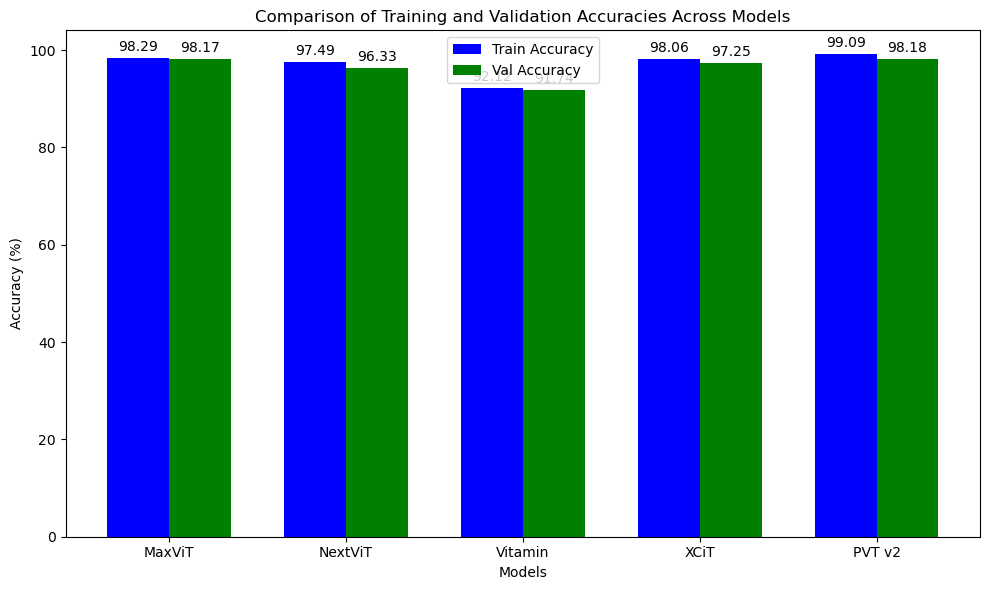

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Model names
models = ['MaxViT', 'NextViT', 'Vitamin', 'XCiT', 'PVT v2']
train_accuracies = [98.29, 97.49, 92.12, 98.06, 99.09]
val_accuracies = [98.17, 96.33, 91.74, 97.25, 98.18]
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.35
index = np.arange(len(models))
bar1 = ax.bar(index, train_accuracies, bar_width, label='Train Accuracy', color='b')
bar2 = ax.bar(index + bar_width, val_accuracies, bar_width, label='Val Accuracy', color='g')

# Labels and Title
ax.set_xlabel('Models')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Comparison of Training and Validation Accuracies Across Models')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(models)
ax.legend()
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords='offset points',
                    ha='center', va='bottom')

add_value_labels(bar1)
add_value_labels(bar2)

plt.tight_layout()
plt.show()